# Animal Vision - Image Classification [Deployment Notebook]

We have completed our experiment in the experiment notebook, now it time to move forward with the deployment stage.

In this notebook we will be using both the small 3 class dataset and the full 30 class dataset of the animal images.

I have made it possible that both the notebooks are standalone notebooks, this makes the workflow and reading much better.

**[NOTE]** - Many of the previous functions in the experiment notebook were created as python scripts and stored in the helper_scripts and model_scripts directory respectively. In this notebook for the speedy workflow, we will be using those functions, you can refer them from those directories.

## Initial Setup

In [4]:
# importing libraries
# File management and utilities packages
import os
import random
import shutil
import pathlib
from pathlib import Path
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from timeit import default_timer as timer
from IPython.display import IFrame
!pip install -q opendatasets
import opendatasets

# Gradio package for deployment
!pip install -q gradio
!pip install -q altair
import gradio as gr

# PyTorch Packages
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
!pip install -q torchinfo
from torchinfo import summary

# My modular script packages
from model_scripts import data_setup, engine, utils, image_plot
from helper_scripts import get_data, plot_loss_curves, get_full_data

# Warnings package
import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

/usr/local/lib/python3.9/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Collecting split-folders

Downloading split_folders-0.5.1-py3-none-any.whl (8.4 kB)

Requirement already satisfied: opendatasets in /usr/local/lib/python3.9/dist-packages (0.1.22)

Requirement already satisfied: click in /usr/local/lib/python3.9/dist-packages (from opendatasets) (8.1.3)

Requirement already satisfied: kaggle in /usr/local/lib/python3.9/dist-packages (from opendatasets) (1.5.12)

Requirement already satisfied: tqdm in /usr/local/lib/python3.9/dist-packages (from opendatasets) (4.64.0)

Requirement already satisfied: six>=1.10 in /usr/lib/python3/dist-packages (from kaggle->opendatasets) (1.14.0)

Requirement already satisfied: python-dateutil in /usr/local/lib/python3.9/dist-packages (from kaggle->opendatasets) (2.8.2)

Requirement already satisfied: requests in /usr/local/lib/python3.9/dist-packages (from kaggle->opendatasets) (2.28.1)

Requirement already satisfied: python-slugify in /usr/lib/python3/dist-packages (from kaggle->opendatasets) (4.0.0)

Requirement already satisfied: certifi in /usr/lib/python3/dist-packages (from kaggle->opendatasets) (2019.11.28)

Requirement already satisfied: urllib3 in /usr/local/lib/python3.9/dist-packages (from kaggle->opendatasets) (1.26.10)

Requirement already satisfied: charset-normalizer<3,>=2 in /usr/local/lib/python3.9/dist-packages (from requests->kaggle->opendatasets) (2.1.0)

Requirement already satisfied: idna<4,>=2.5 in /usr/lib/python3/dist-packages (from requests->kaggle->opendatasets) (2.8)

Installing collected packages: split-folders

Successfully installed split-folders-0.5.1

WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv


Collecting split-folders

Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)

Requirement already satisfied: opendatasets in /usr/local/lib/python3.9/dist-packages (0.1.22)

Requirement already satisfied: click in /usr/local/lib/python3.9/dist-packages (from opendatasets) (8.1.3)

Requirement already satisfied: kaggle in /usr/local/lib/python3.9/dist-packages (from opendatasets) (1.5.12)

Requirement already satisfied: tqdm in /usr/local/lib/python3.9/dist-packages (from opendatasets) (4.64.0)

Requirement already satisfied: six>=1.10 in /usr/lib/python3/dist-packages (from kaggle->opendatasets) (1.14.0)

Requirement already satisfied: python-dateutil in /usr/local/lib/python3.9/dist-packages (from kaggle->opendatasets) (2.8.2)

Requirement already satisfied: requests in /usr/local/lib/python3.9/dist-packages (from kaggle->opendatasets) (2.28.1)

Requirement already satisfied: python-slugify in /usr/lib/python3/dist-packages (from kaggle->opendatasets) (4.0.0)

Requirement already satisfied: certifi in /usr/lib/python3/dist-packages (from kaggle->opendatasets) (2019.11.28)

Requirement already satisfied: urllib3 in /usr/local/lib/python3.9/dist-packages (from kaggle->opendatasets) (1.26.10)

Requirement already satisfied: charset-normalizer<3,>=2 in /usr/local/lib/python3.9/dist-packages (from requests->kaggle->opendatasets) (2.1.0)

Requirement already satisfied: idna<4,>=2.5 in /usr/lib/python3/dist-packages (from requests->kaggle->opendatasets) (2.8)

Installing collected packages: split-folders

Successfully installed split-folders-0.5.1

WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv


In [3]:
# setting up device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# create a function for random seed
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Data Setup

Downloading the 3 class data with the help of helper scripts.

In [4]:
# download the data using the script
get_data.download_data()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  johnp47


Your Kaggle Key:

  ································


100%|██████████| 2.51G/2.51G [00:27<00:00, 96.5MB/s]




Copying raw data...
LION directory created and files copied in "temp_data/animal_data/LION"
TIGER directory created and files copied in "temp_data/animal_data/TIGER"
WOLF directory created and files copied in "temp_data/animal_data/WOLF"

Spliting data in Train and Test set


Copying files: 2432 files [00:06, 371.19 files/s]



temp_data directory is deleted


In [10]:
# data directory
train_dir = Path("data/lion_tiger_wolf/train")
test_dir = Path("data/lion_tiger_wolf/val")

## Feature Extraction - EfficientNetB2

In the experiment notebook we understood that EfficientNetB2 was the best pre-trained network to work with, so lets start with initiating the network as per the pytorch library method.

In [8]:
# Create a function to build a pretrained EfficientNetB2 model
def create_effnetb2_model(num_classes: int=3,
                          seed: int=42):
    """
    Create a feature extraction efficientNetB2 model and transforms.
    Args: 
          num_classes: A integer number for classes in the classifier head.
          seed: A random seed.
    Returns:
          model: A model of EfficientNetB2.
          transforms: A torchvision image transforms based out of the EfficientNetb2.
    """
    # Setup pretrained weights
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    
    # Get EfficientNetB2 transforms
    transforms = weights.transforms()
    
    # Setup the EfficientNetB2 model
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    # Freeze the parameters of the model
    for params in model.parameters():
        params.requires_grad = False
    
    # Change the head classifier to the number of classes as output
    torch.manual_seed(seed)
    model.classifier[1] = nn.Linear(in_features=1408, out_features=num_classes)
    
    return model, transforms

In [7]:
# Create a efficientNetB2 model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

# View the model
summary(effnetb2, (32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [8]:
# create dataloaders for EfficientNetB2
effnetb2_train_dataloader, effnetb2_test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [9]:
# Training the effnetb2 feature extractor model
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# set seed for random and train the model
set_seed(42)
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=effnetb2_train_dataloader,
                                test_dataloader=effnetb2_test_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                epochs=10,
                                device=device,
                                writer=engine.create_writer('animal_vision_mini',
                                                            model_name='effnetb2'))


[INFO] Creating SummaryWriter, saving to: runs/12-12-2022/animal_vision_mini/effnetb2...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5251 , train_acc: 0.8402 | test_loss: 0.2403, test_acc: 0.9355
Epoch: 2 | train_loss: 0.2840 , train_acc: 0.9040 | test_loss: 0.1886, test_acc: 0.9336
Epoch: 3 | train_loss: 0.2313 , train_acc: 0.9269 | test_loss: 0.1652, test_acc: 0.9473
Epoch: 4 | train_loss: 0.2084 , train_acc: 0.9327 | test_loss: 0.1489, test_acc: 0.9551
Epoch: 5 | train_loss: 0.2123 , train_acc: 0.9249 | test_loss: 0.1464, test_acc: 0.9492
Epoch: 6 | train_loss: 0.1834 , train_acc: 0.9365 | test_loss: 0.1412, test_acc: 0.9492
Epoch: 7 | train_loss: 0.1741 , train_acc: 0.9360 | test_loss: 0.1423, test_acc: 0.9492
Epoch: 8 | train_loss: 0.1562 , train_acc: 0.9489 | test_loss: 0.1335, test_acc: 0.9434
Epoch: 9 | train_loss: 0.1624 , train_acc: 0.9425 | test_loss: 0.1329, test_acc: 0.9453
Epoch: 10 | train_loss: 0.1510 , train_acc: 0.9450 | test_loss: 0.1306, test_acc: 0.9473


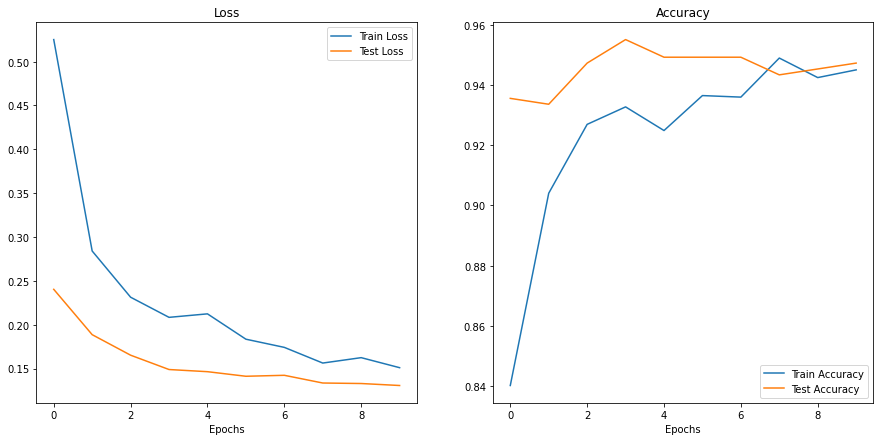

In [10]:
# Plot the loss and accuracy curves from the training result
plot_loss_curves.plot_curves(effnetb2_results)

In [11]:
# saving the model
utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name='pretrained_effnetb2_animal_vision_mini.pth')


[INFO] Saving Model to: models/pretrained_effnetb2_animal_vision_mini.pth


In [12]:
# checking the size of the saved effnetb2 model
effnetb2_model_size = Path('models/pretrained_effnetb2_animal_vision_mini.pth').stat().st_size // (1024*1024)
print(f'Pretrained EfficientNetB2 feature extracted model size: {effnetb2_model_size} MB')

Pretrained EfficientNetB2 feature extracted model size: 29 MB


In [13]:
# count the total number of parameters in effnetb2 model
effnetb2_total_params = sum(torch.numel(params) for params in effnetb2.parameters())
print(f'Total parameters in the EfficientNetB2 model: {effnetb2_total_params}')

Total parameters in the EfficientNetB2 model: 7705221


In [14]:
# Create a dictionary for statistics
effnetb2_stats = {"test_loss": effnetb2_results['test_loss'][-1],
                  'test_acc': effnetb2_results['test_acc'][-1],
                  'number_of_parameters': effnetb2_total_params,
                  'model_size(MB)': effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.13064462156035006,
 'test_acc': 0.947265625,
 'number_of_parameters': 7705221,
 'model_size(MB)': 29}

We have got similar results when we used it in the experiment notebook, this implies we are on the right track.

Lets move forward and use the second pre-trained model.

## Feature Extraction - Vision Transformer(ViT)

In the experiment notebook we looked at a unique model called Vision Transformer, in this notebook we will go a little deep with this pre-trained model along with the EfficientNetB2 model.

In [15]:
# Create a function to build a pretrained Vision Transformer Base 16 model
def create_vit_model(num_classes: int=3,
                     seed: int=42):
    """
    Create a feature extraction ViT Base 16 model and transforms.
    Args: 
          num_classes: A integer number for classes in the classifier head.
          seed: A random seed.
    Returns:
          model: A model of Vision Transformer Base 16.
          transforms: A torchvision image transforms based out of the vit_b_16.
    """
    # Setup pretrained weights
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    
    # Get EfficientNetB2 transforms
    transforms = weights.transforms()
    
    # Setup the EfficientNetB2 model
    model = torchvision.models.vit_b_16(weights=weights)
    
    # Freeze the parameters of the model
    for params in model.parameters():
        params.requires_grad = False
    
    # Change the head classifier with a random seed
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))
    
    return model, transforms

In [16]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [17]:
# summary of the vit model
summary(vit, input_size=(32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [18]:
# create dataloaders for vit model
vit_train_dataloader, vit_test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [19]:
# Training the vit feature extractor model
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# set seed for random and train the model
set_seed(42)
vit_results = engine.train(model=vit,
                           train_dataloader=vit_train_dataloader,
                           test_dataloader=vit_test_dataloader,
                           loss_fn=loss_fn,
                           optimizer=optimizer,
                           epochs=10,
                           device=device,
                           writer=engine.create_writer('animal_vision_mini',
                                                       model_name='vit'))


[INFO] Creating SummaryWriter, saving to: runs/12-12-2022/animal_vision_mini/vit...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2407 , train_acc: 0.9232 | test_loss: 0.1074, test_acc: 0.9551
Epoch: 2 | train_loss: 0.1183 , train_acc: 0.9575 | test_loss: 0.1002, test_acc: 0.9648
Epoch: 3 | train_loss: 0.1024 , train_acc: 0.9633 | test_loss: 0.0958, test_acc: 0.9648
Epoch: 4 | train_loss: 0.0887 , train_acc: 0.9664 | test_loss: 0.0970, test_acc: 0.9551
Epoch: 5 | train_loss: 0.0795 , train_acc: 0.9728 | test_loss: 0.0950, test_acc: 0.9570
Epoch: 6 | train_loss: 0.0731 , train_acc: 0.9732 | test_loss: 0.0960, test_acc: 0.9551
Epoch: 7 | train_loss: 0.0686 , train_acc: 0.9754 | test_loss: 0.0943, test_acc: 0.9551
Epoch: 8 | train_loss: 0.0649 , train_acc: 0.9754 | test_loss: 0.0943, test_acc: 0.9551
Epoch: 9 | train_loss: 0.0612 , train_acc: 0.9759 | test_loss: 0.0943, test_acc: 0.9551
Epoch: 10 | train_loss: 0.0593 , train_acc: 0.9778 | test_loss: 0.0980, test_acc: 0.9551


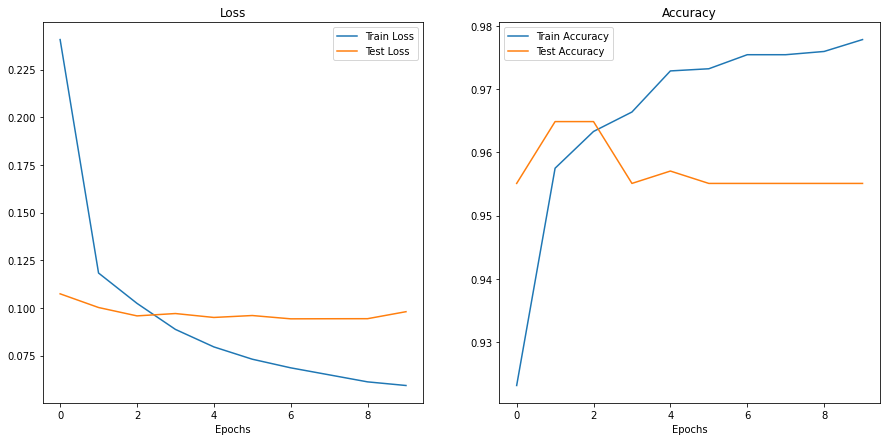

In [20]:
# Plot the loss and accuracy curves from the training result
plot_loss_curves.plot_curves(vit_results)

In [21]:
# saving the model
utils.save_model(model=vit,
                 target_dir='models',
                 model_name='pretrained_vit_animal_vision_mini.pth')


[INFO] Saving Model to: models/pretrained_vit_animal_vision_mini.pth


In [22]:
# checking the size of the saved vit model
vit_model_size = Path('models/pretrained_vit_animal_vision_mini.pth').stat().st_size // (1024*1024)
print(f'Pretrained Vision Transformer Base 16 feature extracted model size: {vit_model_size} MB')

Pretrained Vision Transformer Base 16 feature extracted model size: 327 MB


In [23]:
# count the total number of parameters in vit model
vit_total_params = sum(torch.numel(params) for params in vit.parameters())
print(f'Total parameters in the EfficientNetB2 model: {vit_total_params}')

Total parameters in the EfficientNetB2 model: 85800963


In [24]:
# Create a dictionary for statistics
vit_stats = {"test_loss": vit_results['test_loss'][-1],
             'test_acc': vit_results['test_acc'][-1],
             'number_of_parameters': vit_total_params,
             'model_size(MB)': vit_model_size}
vit_stats

{'test_loss': 0.0980054639003356,
 'test_acc': 0.955078125,
 'number_of_parameters': 85800963,
 'model_size(MB)': 327}

Here also results are similar to the experiment notebook, now lets do some perdiction and comparison.

## Make Prediction using our Models

In [25]:
# Getting all the test paths in a list
print(f'Finding all paths in directory ending with .jpg: {test_dir}')
test_data_paths_raw = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths_raw[:5], len(test_data_paths_raw)

Finding all paths in directory ending with .jpg: data/lion_tiger_wolf/val


([PosixPath('data/lion_tiger_wolf/val/WOLF/images616.jpg'),
  PosixPath('data/lion_tiger_wolf/val/WOLF/images209.jpg'),
  PosixPath('data/lion_tiger_wolf/val/WOLF/images542.jpg'),
  PosixPath('data/lion_tiger_wolf/val/WOLF/images553.jpg'),
  PosixPath('data/lion_tiger_wolf/val/WOLF/images490.jpg')],
 443)

In [26]:
# Cleaning the test path data
test_data_paths_clean = []
for i in test_data_paths_raw:
    img_color_channels = plt.imread(i).shape[2]
    if img_color_channels == 3:
        test_data_paths_clean.append(i)
print(f'Length of the test dataset paths after cleaning the data: {len(test_data_paths_clean)}')

Length of the test dataset paths after cleaning the data: 439


In [27]:
# Create a function to predict and timeit
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str='cuda' if torch.cuda.is_available() else 'cpu') -> List[Dict]:
    # A list to store the prediction result dictionary
    pred_list = []
    
    # Loop through all the test images path
    for path in tqdm(paths):
        
        # A dict to store all the prediction results
        pred_dict = {}
        
        # Get the sample path and actual label names
        pred_dict['image_path'] = path
        class_name = path.parent.stem
        pred_dict['class_name'] = class_name
        
        # Start the timer
        start_time = timer()
        
        # Open image path
        img = Image.open(path)
        
        # Transform and batch the image data
        transformed_img = transform(img).unsqueeze(dim=0).to(device)
        
        # Prepare the model for inference
        model.to(device)
        model.eval()
        
        # Get prediction probabilities, label, and class.
        with torch.inference_mode():
            pred_logit = model(transformed_img)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]
            
            # Adding the prediction probabilities and classes to the dictionary
            pred_dict['pred_prob'] = round(pred_prob.unsqueeze(dim=0).max().cpu().item(), 4)
            pred_dict['pred_class'] = pred_class
            
        # End the timer and calculate and store the time
        end_time = timer()
        pred_dict['time_for_pred'] = round(end_time - start_time, 4)
    
    # Does the prediction match the actual label?
    pred_dict['correct'] = class_name == pred_class
    
    # Add the prediction dictionary to the list
    pred_list.append(pred_dict)
    
    return pred_list      

## EfficientNetB2 Prediction

In [28]:
# Making prediction using the test data with the EfficientNetB2 Model
effnetb2_test_pred_dict = pred_and_store(paths=test_data_paths_clean,
                                         model=effnetb2,
                                         transform=effnetb2_transforms,
                                         class_names=class_names,
                                         device='cpu')

  0%|          | 0/439 [00:00<?, ?it/s]

In [29]:
# check the first 5 prediction
effnetb2_test_pred_dict[:5]

[{'image_path': PosixPath('data/lion_tiger_wolf/val/TIGER/images252.jpg'),
  'class_name': 'TIGER',
  'pred_prob': 0.6468,
  'pred_class': 'TIGER',
  'time_for_pred': 0.0609,
  'correct': True}]

In [30]:
# Turn test prediction dictionary into a dataframe
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dict)
effnetb2_test_pred_df

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/lion_tiger_wolf/val/TIGER/images252.jpg,TIGER,0.6468,TIGER,0.0609,True


In [31]:
# check number of correct predictions
effnetb2_test_pred_df.value_counts('correct')

correct
True    1
dtype: int64

In [32]:
# Average prediction time per image in test data
effnetb2_average_pred_time = round(effnetb2_test_pred_df['time_for_pred'].mean(), 4)
print(f'Average prediction time per image using EfficientNetB2 model: {effnetb2_average_pred_time}')

Average prediction time per image using EfficientNetB2 model: 0.0609


In [33]:
# Adding the average prediction time to the EfficientNetB2 stats dictionary
effnetb2_stats['avg_pred_time_cpu'] = effnetb2_average_pred_time
effnetb2_stats

{'test_loss': 0.13064462156035006,
 'test_acc': 0.947265625,
 'number_of_parameters': 7705221,
 'model_size(MB)': 29,
 'avg_pred_time_cpu': 0.0609}

## Vision Transform Base 16 Prediction

In [34]:
# Making prediction using the test data with the ViT Model
vit_test_pred_dict = pred_and_store(paths=test_data_paths_clean,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device='cpu')

  0%|          | 0/439 [00:00<?, ?it/s]

In [35]:
# check the first 5 prediction
vit_test_pred_dict[:5]

[{'image_path': PosixPath('data/lion_tiger_wolf/val/TIGER/images252.jpg'),
  'class_name': 'TIGER',
  'pred_prob': 0.995,
  'pred_class': 'TIGER',
  'time_for_pred': 0.2474,
  'correct': True}]

In [36]:
# transforming the dict to dataframe
vit_test_pred_df = pd.DataFrame(vit_test_pred_dict)
vit_test_pred_df

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/lion_tiger_wolf/val/TIGER/images252.jpg,TIGER,0.995,TIGER,0.2474,True


In [37]:
# counting the correct values
vit_test_pred_df.value_counts('correct')

correct
True    1
dtype: int64

In [38]:
# Average prediction time per image in test data
vit_average_pred_time = round(vit_test_pred_df['time_for_pred'].mean(), 4)
print(f'Average prediction time per image using Vision Transformer model: {vit_average_pred_time}')

Average prediction time per image using Vision Transformer model: 0.2474


In [39]:
# Adding the average prediction time to the Vision Transform Base 16 stats dictionary
vit_stats['avg_pred_time_cpu'] = vit_average_pred_time
vit_stats

{'test_loss': 0.0980054639003356,
 'test_acc': 0.955078125,
 'number_of_parameters': 85800963,
 'model_size(MB)': 327,
 'avg_pred_time_cpu': 0.2474}

## Comparing model results, prediction time and size

In [40]:
# Turn the stats to dataframe
model_compare_df = pd.DataFrame([effnetb2_stats, vit_stats])

# Adding a model name in dataframe
model_compare_df['model_name'] = ['EffNetB2', 'ViT_B_16']

# Converting the test accuracy in percentage
model_compare_df['test_acc'] = round(model_compare_df['test_acc'] * 100, 2)
model_compare_df

,test_loss,test_acc,number_of_parameters,model_size(MB),avg_pred_time_cpu,model_name
0,0.130645,94.73,7705221,29,0.0609,EffNetB2
1,0.098005,95.51,85800963,327,0.2474,ViT_B_16


In [41]:
# Ratio of Vision Transform to EfficientNetB2
pd.DataFrame(data = model_compare_df.set_index('model_name').loc['ViT_B_16'] / model_compare_df.set_index('model_name').loc['EffNetB2'], columns=['vit_effnetb2_ratio']).T

,test_loss,test_acc,number_of_parameters,model_size(MB),avg_pred_time_cpu
vit_effnetb2_ratio,0.750168,1.008234,11.135432,11.275862,4.062397


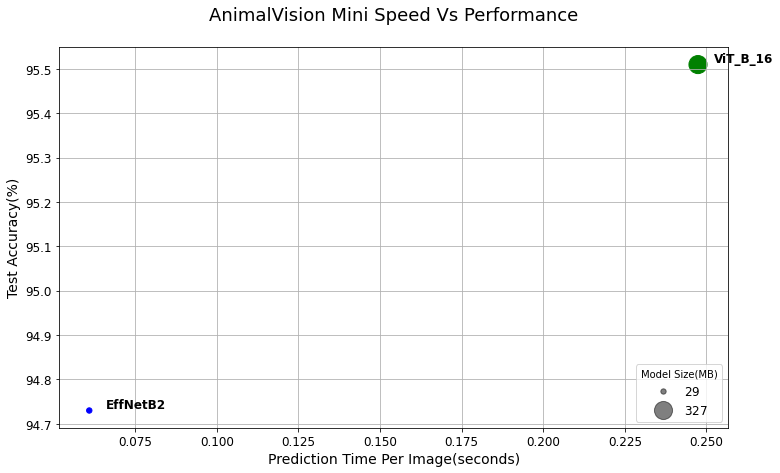

In [42]:
# Visualizing the speed vs performance tradeoff
# Create plot of model comparision
fig, ax = plt.subplots(figsize=(12, 7))
scatter = ax.scatter(data=model_compare_df,
                     x='avg_pred_time_cpu',
                     y='test_acc',
                     c=['blue', 'green'],
                     s='model_size(MB)')
ax.set_title('AnimalVision Mini Speed Vs Performance\n', fontsize=18)
ax.set_xlabel('Prediction Time Per Image(seconds)', fontsize=14)
ax.set_ylabel('Test Accuracy(%)', fontsize=14)
ax.tick_params('both', labelsize=12)
ax.grid(True)

for index, row in model_compare_df.iterrows():
    ax.annotate(text=row['model_name'],
                xy=(row['avg_pred_time_cpu'] + 0.005,
                    row['test_acc'] + 0.005),
                size=12,
                weight='bold')

handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc='lower right',
                              title='Model Size(MB)',
                              fontsize=12)
if Path('images').exists():
    pass
else:
    os.mkdir('images')
plt.savefig('images/AnimalVision_Mini_Speed_Vs_Performance_Chart.jpg');

Comparing both the models we can see the the difference in the model size and the prediction time it takes for a single image.

Lets simplfy the result of the comparison:
 * EfficentNetB2 takes around 0.06 seconds and Vision Transformer takes around 0.25 seconds
 * Accuracy of EfficientNetB2 is 94.7% and Vision Transformer is around 95.5%
 * Size of EfficientNetB2 is 29 MB and Vision Transformer is 327 MB
 
This clearly indicates, that use EfficientNetB2 if you are working on a device that require small models and you can compramize on performance. While Vision Transformer model need good memory to produce good results.

## Gradio Demo using Animal Vision Mini

Now that we loaded and tested our pre-trained models. 

It's time to work on the deployment part of this notebook. We will be using the Gradio library to build our web application, here the application will take an image input of an animal and in return display an output of the animal class and time it took to predict the class.

We will start with the basic of gradio and then move onto deploying it in the real world.

In [43]:
# moving our model to cpu
effnetb2.to('cpu')
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [44]:
# creating a funtion predict() to relate the inputs and outputs
def predict(img) -> Tuple[Dict, float]:
    """
    Transforms the Input Image and returns prediction and time taken to predict.
    """
    # Start the timer
    start_time = timer()
    
    # Transform and batch the image
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model in evaluation and inference mode for prediction
    effnetb2.eval()
    with torch.inference_mode():
        # get the prediction probabilities
        pred_prob = torch.softmax(effnetb2(img), dim=1)
    
    # Creating a dictionary with prediction probabilities and labels as per the gradio format
    pred_labels_and_probs = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    return pred_labels_and_probs, pred_time

In [45]:
# Checking our predict function
# Randomly selecting a image from test data
random_image_path = random.sample(test_data_paths_clean, k=1)[0]

# open the image
image = Image.open(random_image_path)
print(f'[INFO] Predicting an image at path: {random_image_path}\n')

# predicting the image using the predict function
pred_probs_label, pred_time = predict(img=image)
print(f'Prediction probability of the image:\n{pred_probs_label}\nPrediction time: {pred_time}')

[INFO] Predicting an image at path: data/lion_tiger_wolf/val/LION/images120.jpg

Prediction probability of the image:
{'LION': 0.9997977614402771, 'TIGER': 0.00019002359476871789, 'WOLF': 1.2259096365596633e-05}
Prediction time: 0.07366


In [72]:
# Creating a list of example images for the gradio demo
random.seed(42)
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths_clean, k=3)]
example_list

[['data/lion_tiger_wolf/val/TIGER/images473.jpg'],
 ['data/lion_tiger_wolf/val/WOLF/images353.jpg'],
 ['data/lion_tiger_wolf/val/WOLF/_106348480_mediaitem106348478.jpg']]

In [73]:
# Building the gradio interface
# creating the title, description and article
title = 'Animal Vision Mini Demo 🦁 🐯 🐺'
description = 'A Animal Vision Mini project created and build using EfficientNetB2 feature extractor model to clasify images of Lion, Tiger, and Wolf.'
article = 'Created by John Pinto.'

# Creating the demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                             gr.Number(label='Prediction Time (s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo app
demo.launch(debug=False,
            share=True) 

Running on local URL:  http://127.0.0.1:7861


Connected (version 2.0, client OpenSSH_7.6p1)

Authentication (publickey) successful!

Running on public URL: https://04315f54dd9a2c99.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


## Turning demo app into a deployable app

We were able to successfully implement the web app in the notebook, now we need to take in the real work for that we will be uploading it on the HuggingFace spaces.

In [48]:
# Create a demo directory containing a directory for Animal Vision Mini
animalvision_mini_path = Path('demos/animalvision_mini')

# Revome files if already exist
if animalvision_mini_path.exists():
    shutil.rmtree(animalvision_mini_path)
    animalvision_mini_path.mkdir(parents=True,
                                exist_ok=True)
else:
    animalvision_mini_path.mkdir(parents=True,
                                exist_ok=True)
os.listdir('demos')

['animalvision_mini']

In [49]:
# Creating a directory for examples
animalvision_example_path = animalvision_mini_path / 'examples'
animalvision_example_path.mkdir(parents=True,
                                exist_ok=True)

# List of three Images from each class
animalvision_examples = [Path('data/lion_tiger_wolf/val/LION/20180605032116763AfricanLion.jpg'),
                        Path('data/lion_tiger_wolf/val/TIGER/TSqnkJJbXuDTgtdfQkjkcZ-320-80.jpg'),
                        Path('data/lion_tiger_wolf/val/WOLF/frontiers-in-ecology-and-evolution-dog-wolf-hybrids.jpg')]

# Copying the three images to the examples direcctory
for example in animalvision_examples:
    print(f'[INFO] Copying {example} to {animalvision_example_path}')
    shutil.copy2(src=example, dst=animalvision_example_path)

[INFO] Copying data/lion_tiger_wolf/val/LION/20180605032116763AfricanLion.jpg to demos/animalvision_mini/examples
[INFO] Copying data/lion_tiger_wolf/val/TIGER/TSqnkJJbXuDTgtdfQkjkcZ-320-80.jpg to demos/animalvision_mini/examples
[INFO] Copying data/lion_tiger_wolf/val/WOLF/frontiers-in-ecology-and-evolution-dog-wolf-hybrids.jpg to demos/animalvision_mini/examples


In [50]:
# Now format the example as per gradio requirement
example_list = [['examples/' + example] for example in os.listdir(animalvision_example_path) if example.endswith('.jpg')]
example_list

[['examples/frontiers-in-ecology-and-evolution-dog-wolf-hybrids.jpg'],
 ['examples/TSqnkJJbXuDTgtdfQkjkcZ-320-80.jpg'],
 ['examples/20180605032116763AfricanLion.jpg']]

In [57]:
# Move the saved models files to the demos directory
# source and destination path
animalvision_mini_effnetb2_model_path = 'models/pretrained_effnetb2_animal_vision_mini.pth'
animalvision_mini_effnetb2_model_destination = animalvision_mini_path / animalvision_mini_effnetb2_model_path.split('/')[1]

# Moving the model
try:
    print(f'[INFO] Moving the model from {animalvision_mini_effnetb2_model_path} to {animalvision_mini_effnetb2_model_destination}\n')
    shutil.move(src=animalvision_mini_effnetb2_model_path,
               dst=animalvision_mini_effnetb2_model_destination)
    print(f'[INFO] Model move complete.')
except:
    print(f'[INFO] Model doesnot exist in {animalvision_mini_effnetb2_model_path}.')
    print(f'[INFO] Model is already moved to {animalvision_mini_effnetb2_model_destination},\
          \nwhether model exist or not in "{animalvision_mini_effnetb2_model_destination}"? {animalvision_mini_effnetb2_model_destination.exists()}')

[INFO] Moving the model from models/pretrained_effnetb2_animal_vision_mini.pth to demos/animalvision_mini/pretrained_effnetb2_animal_vision_mini.pth

[INFO] Model doesnot exist in models/pretrained_effnetb2_animal_vision_mini.pth.
[INFO] Model is already moved to demos/animalvision_mini/pretrained_effnetb2_animal_vision_mini.pth,          
whether model exist or not in "demos/animalvision_mini/pretrained_effnetb2_animal_vision_mini.pth"? True


### Creating a Effnetb2 model script - model.py (model creation similar to the above function)

In [59]:
%%writefile demos/animalvision_mini/model.py
import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int=3,
                          seed: int=42):
    """
    Create a feature extraction efficientNetB2 model and transforms.
    Args: 
          num_classes: A integer number for classes in the classifier head.
          seed: A random seed.
    Returns:
          model: A model of EfficientNetB2.
          transforms: A torchvision image transforms based out of the EfficientNetb2.
    """
    # Setup pretrained weights
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    
    # Get EfficientNetB2 transforms
    transforms = weights.transforms()
    
    # Setup the EfficientNetB2 model
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    # Freeze the parameters of the model
    for params in model.parameters():
        params.requires_grad = False
    
    # Change the head classifier with a random seed
    torch.manual_seed(seed)
    model.classifier[1] = nn.Linear(in_features=1408, out_features=num_classes)
    
    return model, transforms

Writing demos/animalvision_mini/model.py


### Creating a script for the core part of the web application as per HuggingFace - app.py

In [63]:
%%writefile demos/animalvision_mini/app.py
import gradio as gr
import os
import torch
from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Defining class names
class_names = ['LION', 'TIGER', 'WOLF']

# Model and transform preparation using create_effnetb2_model function
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

# Load saved weights from the saved model
effnetb2.load_state_dict(torch.load(f='pretrained_effnetb2_animal_vision_mini.pth',
                                   map_location=torch.device('cpu')))

# create a predict function to connect inputs and outputs
def predict(img) -> Tuple[Dict, float]:
    """
    Transforms the Input Image and returns prediction and time taken to predict.
    """
    # Start the timer
    start_time = timer()
    
    # Transform and batch the image
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model in evaluation and inference mode for prediction
    effnetb2.eval()
    with torch.inference_mode():
        # get the prediction probabilities
        pred_prob = torch.softmax(effnetb2(img), dim=1)
    
    # Creating a dictionary with prediction probabilities and labels as per the gradio format
    pred_labels_and_probs = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    return pred_labels_and_probs, pred_time

# Building the gradio interface
# creating the title, description and article
title = 'Animal Vision Mini 🦁 🐯 🐺'
description = 'A Animal Vision Mini project created and build using EfficientNetB2 feature extractor model to clasify images of Lion, Tiger, and Wolf.'
article = 'Created by John Pinto.'

# Creating the example list
example_list = [['examples/' + example] for example in os.listdir('examples') if example.endswith('.jpg')]

# Creating the gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                             gr.Number(label='Prediction Time (s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo app
demo.launch()

Writing demos/animalvision_mini/app.py


### Creating the requirement file for the app - requirements.txt

In [69]:
%%writefile demos/animalvision_mini/requirements.txt
torch == 1.12.0
torchvision == 0.13.0
gradio == 3.12.0

Writing demos/animalvision_mini/requirements.txt


### Deploy the Animal Vision Mini to Hugging Face

In [75]:
# Check all the files in demos directory
os.listdir('demos/animalvision_mini')

['requirements.txt',
 'app.py',
 'pretrained_effnetb2_animal_vision_mini.pth',
 'examples',
 'model.py']

In [81]:
# Compress the necessary files into zip file
!cd demos/animalvision_mini && zip -r ../animalvision_mini.zip * -x '*.pyc' '*.ipynb' '*__pycache__*' '*ipynb_checkpoints*'

  adding: app.py (deflated 56%)
  adding: examples/ (stored 0%)
  adding: examples/frontiers-in-ecology-and-evolution-dog-wolf-hybrids.jpg (deflated 2%)
  adding: examples/TSqnkJJbXuDTgtdfQkjkcZ-320-80.jpg (deflated 1%)
  adding: examples/20180605032116763AfricanLion.jpg (deflated 0%)
  adding: model.py (deflated 57%)
  adding: pretrained_effnetb2_animal_vision_mini.pth (deflated 8%)
  adding: requirements.txt (deflated 18%)


In [99]:
# Extracting Zip file
shutil.unpack_archive(filename='demos/animalvision_mini.zip',
                     extract_dir='animalvision_mini')

In [5]:
# Displaying Animal Vision Mini from hugging Face
IFrame(src="https://johnpinto-animalvision-mini.hf.space",
      width=1200,
      height=750)

Finally, we were able to create and deploy our first web application animal vision mini on the HuggingFace spaces.

You can check over here the fully running web application, click on the link -> [Animal Vision Mini](https://johnpinto-animalvision-mini.hf.space)

## Creating Animal Vision Big

We have created animal vision mini, which classifies 3 different animals. 

Now, we will take it big, create a web application that can classify 30 different animals.

In [5]:
# Setting up the training and testing directory
animal30_train_dir = Path('data/animal30/raw-animals-image-dataset/train')
animal30_test_dir = Path('data/animal30/raw-animals-image-dataset/val')

In [6]:
# walkthrough of train and test dataset
total_files = []
for dirpath, dirnames, filenames in os.walk('data/animal30/raw-animals-image-dataset'):
    total_files.append(len(filenames))
    print(f'There are {len(dirnames)} directories and {len(filenames)} files in "{dirpath}".')
print(f'Total files present in the animal30 dataset: {sum(total_files)}')

There are 2 directories and 0 files in "data/animal30/raw-animals-image-dataset".
There are 30 directories and 0 files in "data/animal30/raw-animals-image-dataset/train".
There are 0 directories and 602 files in "data/animal30/raw-animals-image-dataset/train/RHINO".
There are 0 directories and 626 files in "data/animal30/raw-animals-image-dataset/train/OSTRICH".
There are 0 directories and 716 files in "data/animal30/raw-animals-image-dataset/train/BEAR".
There are 0 directories and 655 files in "data/animal30/raw-animals-image-dataset/train/SQUIREL".
There are 0 directories and 625 files in "data/animal30/raw-animals-image-dataset/train/CROCODILES".
There are 0 directories and 656 files in "data/animal30/raw-animals-image-dataset/train/MONKEY".
There are 0 directories and 713 files in "data/animal30/raw-animals-image-dataset/train/DEER".
There are 0 directories and 693 files in "data/animal30/raw-animals-image-dataset/train/COW".
There are 0 directories and 613 files in "data/animal30

In [9]:
# Creating a model and transforms
# Using EfficientnetB2 as a model
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=30)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [10]:
# summary of the model
summary(model=effnetb2,
       input_size=(32, 3, 224, 224),
       col_names=['input_size',
                 'output_size',
                 'num_params',
                 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 30]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [11]:
# Creating augmentation transforms for train dataset
effnetb2_aug_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

# Print both transforms with and without augmentation
print(f'{effnetb2_transforms}\n{effnetb2_aug_transforms}')

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)


In [12]:
# Creating PyTorch datasets and dataloaders of the training and testing datasets.
# Creating PyTorch datasets
animal30_train_dataset = torchvision.datasets.ImageFolder(root=animal30_train_dir,
                                                          transform=effnetb2_aug_transforms)
animal30_test_dataset = torchvision.datasets.ImageFolder(root=animal30_test_dir,
                                                         transform=effnetb2_transforms)
animal30_class_names = animal30_train_dataset.classes

animal30_train_dataset, animal30_test_dataset, animal30_class_names

(Dataset ImageFolder
     Number of datapoints: 19747
     Root location: data/animal30/raw-animals-image-dataset/train
     StandardTransform
 Transform: Compose(
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ImageClassification(
                crop_size=[288]
                resize_size=[288]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            )
            ),
 Dataset ImageFolder
     Number of datapoints: 4881
     Root location: data/animal30/raw-animals-image-dataset/val
     StandardTransform
 Transform: ImageClassification(
                crop_size=[288]
                resize_size=[288]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ),
 ['BEAR',
  'CATS',
  'CHEETAH',
  'COW',
  'CROCODILES',


In [14]:
# Creating dataloaders of the animal30 datasets
num_workers = os.cpu_count()

animal30_train_dataloaders = DataLoader(dataset=animal30_train_dataset,
                                       batch_size=32,
                                       shuffle=True,
                                       num_workers=num_workers,
                                       pin_memory=True)
animal30_test_dataloaders = DataLoader(dataset=animal30_test_dataset,
                                       batch_size=32,
                                       shuffle=False,
                                       num_workers=num_workers,
                                       pin_memory=True)

animal30_train_dataloaders, animal30_test_dataloaders

(<torch.utils.data.dataloader.DataLoader at 0x7fbc5135b3a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fbc5135bd90>)

In [15]:
# Training the EfficientNetB2 model with the animal30 dataset
# Setting up loss and optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# training the model using the model script engine.py
set_seed(seed=42)
animal30_effnetb2_results = engine.train(model=effnetb2,
                                        train_dataloader=animal30_train_dataloaders,
                                        test_dataloader=animal30_test_dataloaders,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        epochs=5,
                                        device=device,
                                        writer=engine.create_writer(experiment_name='animal_vision_big',
                                                                    model_name='effnetb2'))


[INFO] Creating SummaryWriter, saving to: runs/28-12-2022/animal_vision_big/effnetb2...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5541 , train_acc: 0.7477 | test_loss: 1.0599, test_acc: 0.8961
Epoch: 2 | train_loss: 1.2979 , train_acc: 0.8056 | test_loss: 1.0246, test_acc: 0.9004
Epoch: 3 | train_loss: 1.2780 , train_acc: 0.8105 | test_loss: 1.0116, test_acc: 0.9038
Epoch: 4 | train_loss: 1.2596 , train_acc: 0.8199 | test_loss: 1.0092, test_acc: 0.9045
Epoch: 5 | train_loss: 1.2516 , train_acc: 0.8213 | test_loss: 1.0022, test_acc: 0.9079


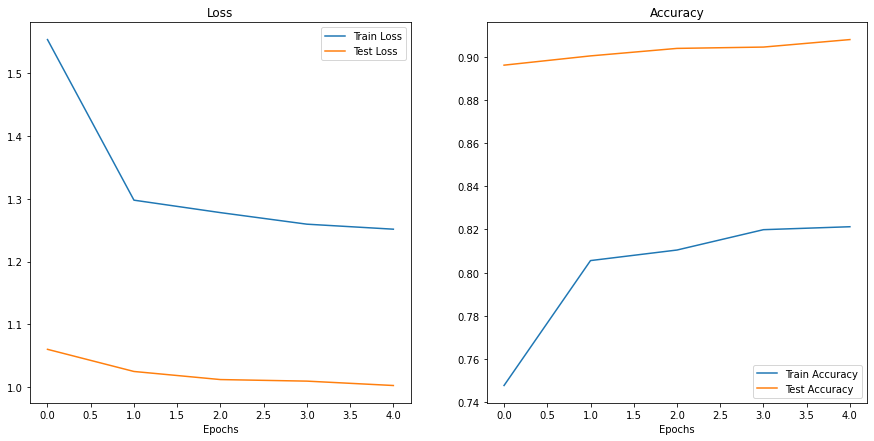

In [16]:
# Plot loss and acurracy curves from the efficientnetB2 result
plot_loss_curves.plot_curves(animal30_effnetb2_results)

In [17]:
# Saving the model
# Saved model path
utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name='pretrained_effnetb2_animal_vision_big.pth')


[INFO] Saving Model to: models/pretrained_effnetb2_animal_vision_big.pth


In [18]:
# Checking extra details of our saved model
animal30_effnetb2_saved_model_size = Path('models/pretrained_effnetb2_animal_vision_big.pth').stat().st_size // (1024*1024)
print(f'Pretrained EfficientNetB2 feature extracted model size: {animal30_effnetb2_saved_model_size} MB')

Pretrained EfficientNetB2 feature extracted model size: 29 MB


In [19]:
# Check the total parameters and total trainable parameters
animal30_effnetb2_total_params = sum(p.numel() for p in effnetb2.parameters())
animal30_effnetb2_trainable_params = sum(p.numel() for p in effnetb2.parameters() if p.requires_grad)
print(f'Total parameters of animal30 EffNetB2 Model: {animal30_effnetb2_total_params}')
print(f'Total trainable parameters of animal30 EffNetB2 Model: {animal30_effnetb2_trainable_params}')
print(f'Total non-trainable parameters of animal30 EffNetB2 Model: {animal30_effnetb2_total_params-animal30_effnetb2_trainable_params}')

Total parameters of animal30 EffNetB2 Model: 7743264
Total trainable parameters of animal30 EffNetB2 Model: 42270
Total non-trainable parameters of animal30 EffNetB2 Model: 7700994


The result we have got from EfficientNetB2 is good around 90% accuracy on the test data. 

We can also see that the plots are indicating overfitting this might be due to the less epochs we have trained the model, there is a high chance that if we increase the model epochs and also apply learning rate scheduler, results might change and be much better then the current ones.

### Turning the Animal Vision Big into a Deployable app

In [22]:
# Create Animal Vision Big demo path
animalvision_big_demo_path = Path('demos/animalvision_big')

# Create a directory for animal vision big
animalvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Create a exmaples directory for animal vision  big
(animalvision_big_demo_path / 'examples').mkdir(parents=True, exist_ok=True)

In [23]:
# Adding image files in the examples directory
animal30_exmaples_list = [Path('data/animal30/raw-animals-image-dataset/val/BEAR/polar-bear-7.jpg'),
                          Path('data/animal30/raw-animals-image-dataset/val/CHEETAH/cheetah_16x9.jpg'),
                          Path('data/animal30/raw-animals-image-dataset/val/PANDA/animal-hero-panda3.jpg'),
                          Path('data/animal30/raw-animals-image-dataset/val/GIRAFFE/123093_web.jpg'),
                          Path('data/animal30/raw-animals-image-dataset/val/RHINO/rhino-facts.jpg')]
for i in animal30_exmaples_list:
    print(f'[INFO] Copying files from "{i}" to "demos/animalvision_big/examples"')
    shutil.copy2(src=i, dst='demos/animalvision_big/examples')

shutil.move(src='models/pretrained_effnetb2_animal_vision_big.pth', dst='demos/animalvision_big')

[INFO] Copying files from "data/animal30/raw-animals-image-dataset/val/BEAR/polar-bear-7.jpg" to "demos/animalvision_big/examples"
[INFO] Copying files from "data/animal30/raw-animals-image-dataset/val/CHEETAH/cheetah_16x9.jpg" to "demos/animalvision_big/examples"
[INFO] Copying files from "data/animal30/raw-animals-image-dataset/val/PANDA/animal-hero-panda3.jpg" to "demos/animalvision_big/examples"
[INFO] Copying files from "data/animal30/raw-animals-image-dataset/val/GIRAFFE/123093_web.jpg" to "demos/animalvision_big/examples"
[INFO] Copying files from "data/animal30/raw-animals-image-dataset/val/RHINO/rhino-facts.jpg" to "demos/animalvision_big/examples"


'demos/animalvision_big/pretrained_effnetb2_animal_vision_big.pth'

In [24]:
# Saving Animal30 class names in a file.
# Viewing the first 10 class names
print(animal30_class_names[:10])

# Creating a text file path for the class names
animal30_class_names_path = animalvision_big_demo_path / 'class_names.txt'

# Writing the class names in the text file
with open(animal30_class_names_path, 'w') as f:
    print(f'\n[INFO] Saving Animal30 class names to {animal30_class_names_path}')
    f.write('\n'.join(animal30_class_names))

['BEAR', 'CATS', 'CHEETAH', 'COW', 'CROCODILES', 'DEER', 'DOGS', 'ELEPHANT', 'GIRAFFE', 'GOAT']

[INFO] Saving Animal30 class names to demos/animalvision_big/class_names.txt


In [25]:
# Reading the lines in the text file
with open(animal30_class_names_path, 'r') as f:
    animal30_class_names_loaded = [i.strip() for i in f.readlines()]
print(animal30_class_names_loaded[:10])

['BEAR', 'CATS', 'CHEETAH', 'COW', 'CROCODILES', 'DEER', 'DOGS', 'ELEPHANT', 'GIRAFFE', 'GOAT']


### Creating Animal Vision Big model in the demos directory - model.py

In [26]:
%%writefile demos/animalvision_big/model.py
import torch
import torchvision
from torch import nn

def create_effnet_model(num_classes: int=30,
                        seed: int=42):
    """
    Create a feature extraction efficientNetB2 model and transforms.
    Args: 
          num_classes: A integer number for classes in the classifier head.
          seed: A random seed.
    Returns:
          model: A model of EfficientNetB2.
          transforms: A torchvision image transforms based out of the EfficientNetb2.
    """
    # Create weights, transform and model of effnetb2
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transform = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    # Freeze all the layers of the model
    for param in model.parameters():
        param.requires_grad = False
    
    # Change the head of the model
    torch.manual_seed(seed)
    model.classifier[1] = nn.Linear(in_features=1408, out_features=num_classes)
    
    return model, transform

Writing demos/animalvision_big/model.py


### Creating Animal Vision Big Gradio Core File - app.py

In [27]:
%%writefile demos/animalvision_big/app.py
import gradio as gr
import os
import torch

from model import create_effnet_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# setup class names
with open('class_names.txt', 'r') as f:
    class_names = [i.strip() for i in f.readlines()]

# Create model
effnetb2, effnetb2_transforms = create_effnet_model(num_classes=len(class_names))

# Load saved weights
effnetb2.load_state_dict(torch.load(f='pretrained_effnetb2_animal_vision_big.pth',
                                    map_location=torch.device('cpu')))

# Create Predict function
def predict(img) -> Tuple[Dict, float]:
    """
    Transforms the Input Image and returns prediction and time taken to predict.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the image and add a batch
    img = effnetb2_transforms(img).unsqueeze(dim=0)
    
    # Put the model in evaluation and inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Get prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and probability dictionary for each prediction class as per the gradio requirement
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    return pred_labels_and_probs, pred_time

# Create gradio app
# Title, description and article in gradio app
title = 'Animal Vision Big 🦁 🐯 🐺 👀'
description = 'A Animal Vision Big project created and build using EfficientNetB2 feature extractor model to clasify images of 30 different animals #Github link of class_names.txt#.'
article = 'Created by John Pinto.'

# Create example list
example_list = [['examples/' + example] for example in os.listdir('examples') if example.endswith('.jpg')]

# Creating a gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=5, label='Predictions'),
                             gr.Number(label='Prediction Time (seconds)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)
# Launch the app
demo.launch()

Writing demos/animalvision_big/app.py


### Create a Requirement file - requirements.txt

In [28]:
%%writefile demos/animalvision_big/requirements.txt
torch == 1.12.0
torchvision == 0.13.0
gradio == 3.12.0

Writing demos/animalvision_big/requirements.txt


In [29]:
# Downloading the animal vision big directory
# Zip the directory and exclude files that are not required
!cd demos/animalvision_big && zip -r ../animalvision_big.zip * -x '*.pyc' '*.ipynb' '*__pycache__*' '*ipynb_checkpoints*'

# unpacking the zip file
shutil.unpack_archive('demos/animalvision_big.zip',
                      extract_dir='animalvision_big')

  adding: app.py (deflated 56%)
  adding: class_names.txt (deflated 33%)
  adding: examples/ (stored 0%)
  adding: examples/cheetah_16x9.jpg (deflated 1%)
  adding: examples/rhino-facts.jpg (deflated 0%)
  adding: examples/123093_web.jpg (deflated 1%)
  adding: examples/animal-hero-panda3.jpg (deflated 0%)
  adding: examples/polar-bear-7.jpg (deflated 1%)
  adding: model.py (deflated 55%)
  adding: pretrained_effnetb2_animal_vision_big.pth (deflated 8%)
  adding: requirements.txt (deflated 18%)


In [8]:
# Displaying Animal Vision Big from Hugging Face
IFrame(src='https://johnpinto-animal-vision-big.hf.space',
      width=900,
      height=750)

Finally the Animal Vision Big is been created and live on HuggingFace. You can check the live version overe here -> [Animal Vision Big](https://johnpinto-animal-vision-big.hf.space)